In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Colab Notebooks"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
a	     image_captioning.ipynb    mbart_translation.ipynb
genre.ipynb  landmark_retrieval.ipynb


In [2]:
%cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.neighbors import KDTree, NearestNeighbors
import tensorflow as tf
import keras
from keras import layers, optimizers
from keras.models import Model
from keras.layers import Dense, Flatten, Input
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.applications.vgg16 import VGG16

In [4]:
roots = []
for root, dirs, files in os.walk("a"):
  if len(root) == 5:
    roots.append(root)

In [5]:
imgs = []
for root in roots:
    for filename in os.listdir(root):
        img = cv.imread(os.path.join(root,filename))
        img = cv.resize(img, (224, 224), interpolation = cv.INTER_AREA)
        if img is not None:
            imgs.append(img)
            print(os.path.join(root,filename))

a/b/f/abf7162e2cf89d65.jpg
a/b/f/abf2c128ab7ee430.jpg
a/b/f/abf866c34ef0423f.jpg
a/b/f/abf2af8f6998b931.jpg
a/b/f/abf36b24fc5ff042.jpg
a/b/f/abfaf16cb8f68af3.jpg
a/b/f/abf73039d2f6307e.jpg
a/b/f/abfd03aaa8b36d74.jpg
a/b/f/abf843e038b95462.jpg
a/b/f/abf84967efe9be45.jpg
a/b/f/abf0e3f702469db8.jpg
a/b/f/abfcb68e87d9a7c8.jpg
a/b/f/abf0c69f305742ff.jpg
a/b/f/abf65b9893d5ce85.jpg
a/b/f/abf690406e5f914c.jpg
a/b/f/abfca07765bdfef8.jpg
a/b/f/abfad89d1d7071c6.jpg
a/b/e/abefd7a9f8e19ac8.jpg
a/b/e/abe25f6cd0c53b54.jpg
a/b/e/abe2bd7ef0bc836f.jpg
a/b/e/abe137f3f2cb86e8.jpg
a/b/e/abe01daeb31340a6.jpg
a/b/e/abe058ff5810f46a.jpg
a/b/e/abe930de36543f83.jpg
a/b/e/abe29964b032093e.jpg
a/b/e/abe29dea2869c82e.jpg
a/b/e/abefa23d6199f5d0.jpg
a/b/e/abe38909a31c2bac.jpg
a/b/e/abe9ea9aa0e458ee.jpg
a/b/e/abec693cd9fb4e68.jpg
a/b/e/abe6273f0cf83510.jpg
a/b/e/abefda23e5db3f59.jpg
a/b/e/abef48b2f0489bee.jpg
a/b/e/abee2120f91320eb.jpg
a/b/e/abe98a65d5478ee8.jpg
a/b/e/abe6b3ab38e5503c.jpg
a/b/e/abeab7fdfe06a97a.jpg
a

In [6]:
imgs = np.array(imgs)
imgs = np.divide(imgs, 255)
imgs.shape

(4756, 224, 224, 3)

In [7]:
# Use pretrained model to get feature embeddings
vggmodel = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
for layers in (vggmodel.layers)[:19]:
    print(layers)
    layers.trainable = False

In [8]:
feature_embeddings = vggmodel.layers[-1].output
model = Model(vggmodel.input, feature_embeddings)

In [9]:
prediction = model.predict(imgs)

In [10]:
prediction.shape

(4756, 7, 7, 512)

In [11]:
prediction = np.reshape(prediction, (4756, 25088))

**Image Retrieval**

In [12]:
# KNN search by Euclidean distance
# nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(prediction)
# distances, indices = nbrs.kneighbors(prediction)
kdt = KDTree(prediction, leaf_size=30, metric='euclidean')
distances, indices = kdt.query(prediction, k=10, return_distance=True)

In [13]:
indices, distances

(array([[   0, 4575, 4668, ..., 4226, 3177,  893],
        [   1,  655, 3133, ...,  623, 2813, 4319],
        [   2, 3209, 1462, ..., 1766, 3245, 4041],
        ...,
        [4753, 2925,  334, ...,  287,  458, 3593],
        [4754, 4226, 1739, ..., 3542, 2385, 3845],
        [4755,  219,  323, ..., 1608, 1489, 4349]]),
 array([[ 0.        , 42.4056264 , 42.64736371, ..., 43.26254706,
         43.40617897, 43.40751985],
        [ 0.        , 26.78697792, 26.90326958, ..., 28.66832796,
         28.84678322, 29.0374474 ],
        [ 0.        , 45.71417246, 45.89667435, ..., 46.26386372,
         46.28488408, 46.31528237],
        ...,
        [ 0.        , 32.83196624, 33.33091936, ..., 34.66481862,
         34.73473057, 34.78943615],
        [ 0.        , 33.90849324, 37.08972122, ..., 37.72377537,
         38.24465417, 38.43650557],
        [ 0.        , 38.66373138, 39.4377289 , ..., 40.22341773,
         40.24922387, 40.39608447]]))

In [39]:
image_idx = 31 # Set index of query image

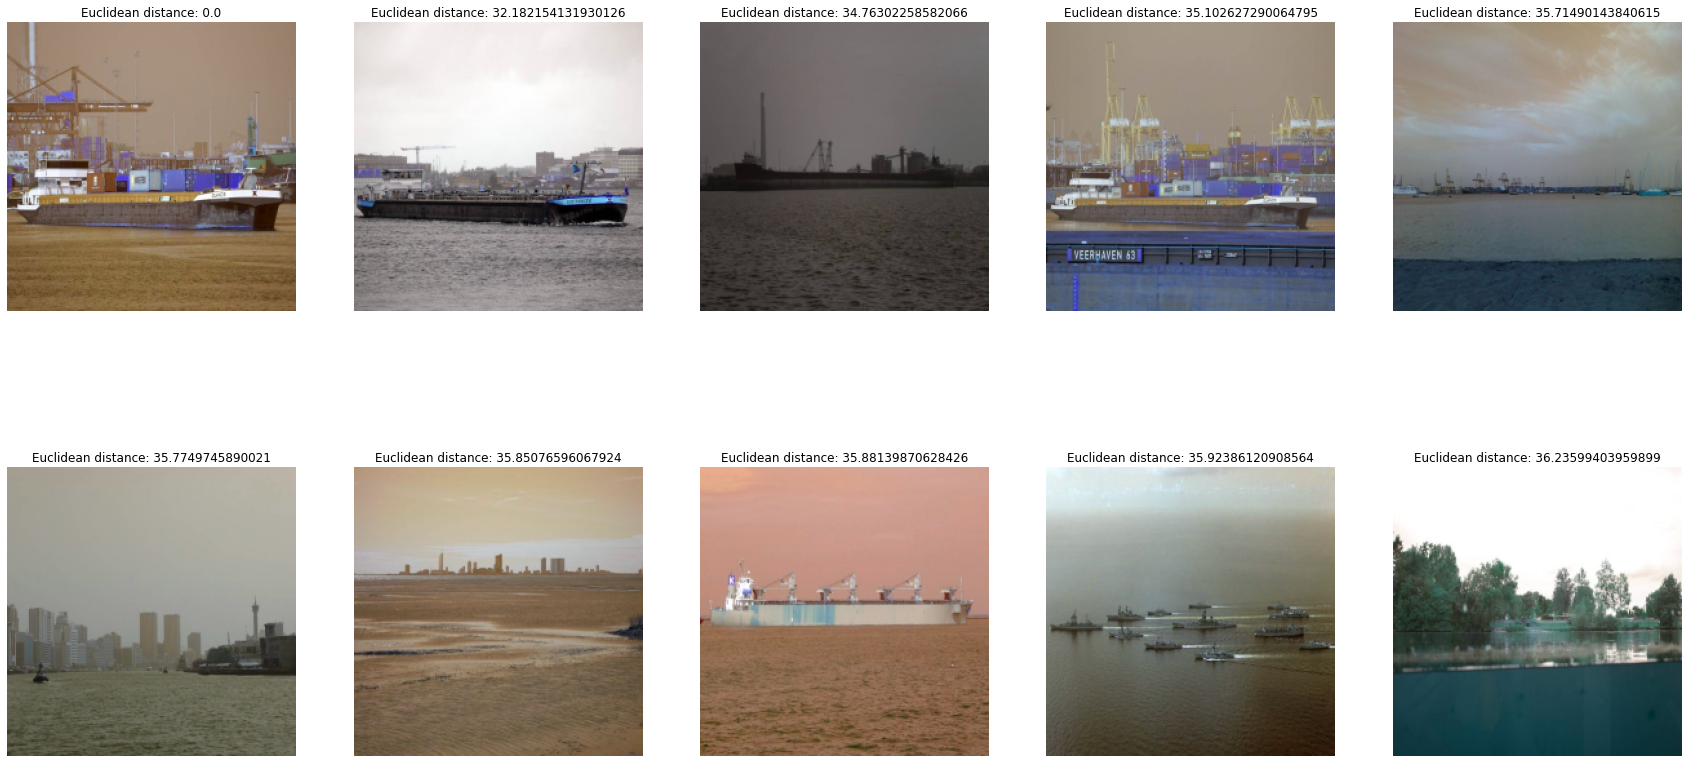

In [40]:
knn_imgs = indices[image_idx]
knn_distances = distances[image_idx]
plt.figure(figsize=(30, 15))
for i, idx in enumerate(knn_imgs, 1):
    ax = plt.subplot(2, 5, i)
    plt.imshow(imgs[idx])
    plt.title("Euclidean distance: " + str(knn_distances[i - 1]))
    plt.axis("off")

**Image Reranking**